In [ ]:
from glob import glob
from emocodes import CodeTimeSeries

raw_dir = '/Users/catcamacho/Box/CCP/EmoCodes_project/reliability_data/raw/'
raw_files = glob(raw_dir + 'AHKJ*_subjective_char*')
video = '/Users/catcamacho/Box/CCP/EmoCodes_project/reliability_data/episodes/AHKJ_S1E2.mp4'
preproc_dir = '/Users/catcamacho/Box/CCP/EmoCodes_project/reliability_data/processed/AHKJ_S1E2/'

cts = CodeTimeSeries(sampling_rate=10)
for file in raw_files:
    initials = file[-6:-4]
    print(initials)
    cts.proc_codes_file(codes_file=file, video_file=video, save_file_name=preproc_dir+'subjective_character_Julien_timeseries_{0}'.format(initials))

In [8]:
# pull in data and assign processing directories
from glob import glob
preproc_dir = '/Users/catcamacho/Box/CCP/EmoCodes_project/reliability_data/processed/'

episode = 'AHKJ_S1E2'
#episode = 'MLP_S8E3'
string_vars = ['d_other_name']
files = sorted(glob(preproc_dir + '{0}/subjective_char*'.format(episode)))
files

['/Users/catcamacho/Box/CCP/EmoCodes_project/reliability_data/processed/AHKJ_S1E2/subjective_character_Julien_timeseries_DB_20210409-114125.csv',
 '/Users/catcamacho/Box/CCP/EmoCodes_project/reliability_data/processed/AHKJ_S1E2/subjective_character_Julien_timeseries_NS_20210409-104140.csv',
 '/Users/catcamacho/Box/CCP/EmoCodes_project/reliability_data/processed/AHKJ_S1E2/subjective_character_Julien_timeseries_RK_20210409-114129.csv',
 '/Users/catcamacho/Box/CCP/EmoCodes_project/reliability_data/processed/AHKJ_S1E2/subjective_character_Julien_timeseries_sy_20210409-114131.csv']

******************* c_anger_body *********************


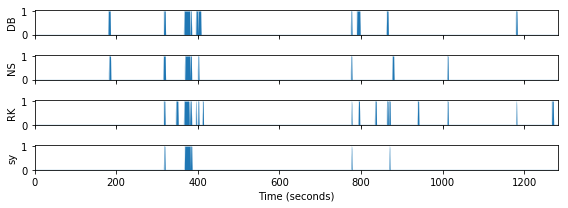

 
******************* c_anger_face *********************


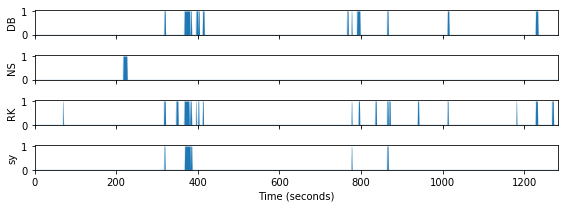

 
******************* c_anger_verbal *********************


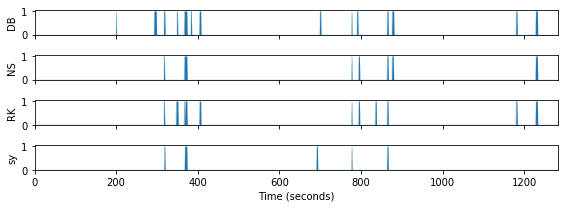

 
******************* c_disgust_body *********************


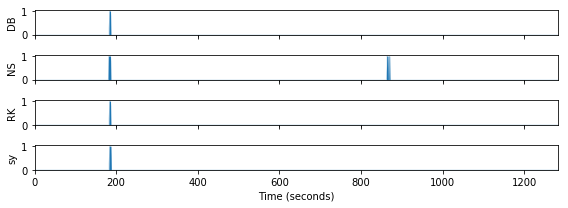

 
******************* c_disgust_face *********************


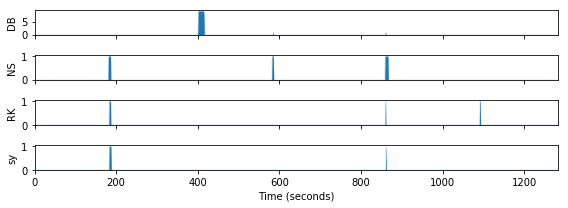

 
******************* c_disgust_verbal *********************


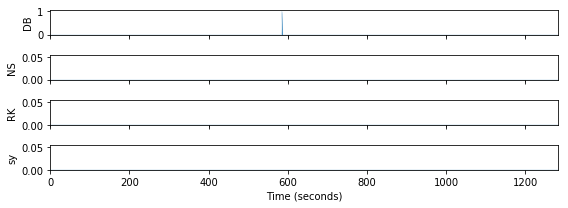

 
******************* c_excite_body *********************


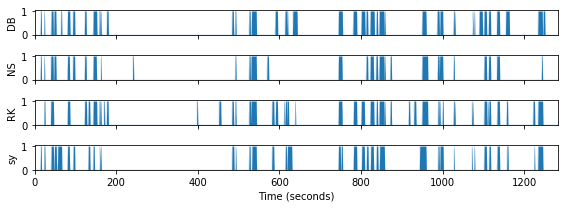

 
******************* c_excite_face *********************


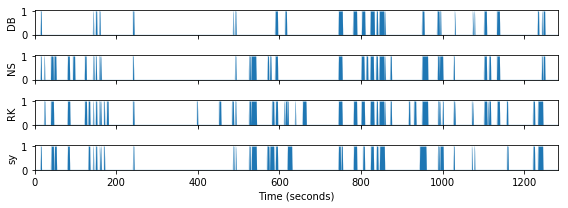

 
******************* c_excite_verbal *********************


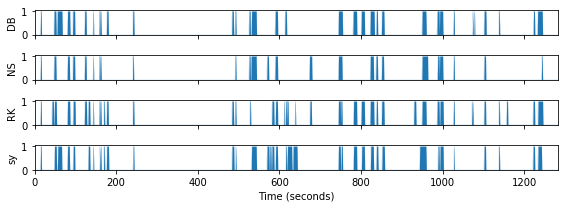

 
******************* c_fear_body *********************


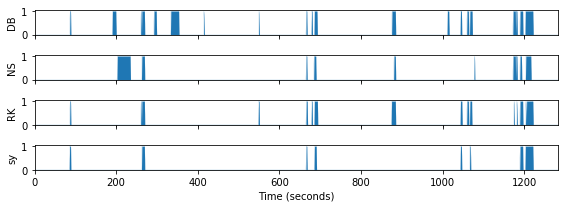

 
******************* c_fear_face *********************


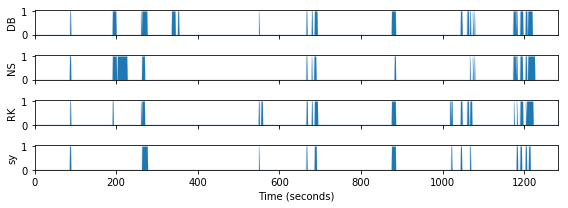

 
******************* c_fear_verbal *********************


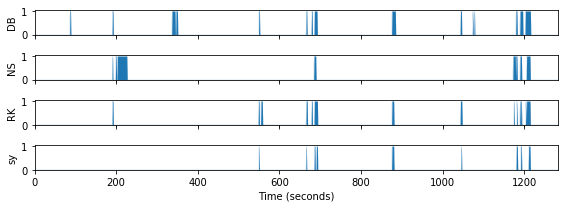

 
******************* c_happy_body *********************


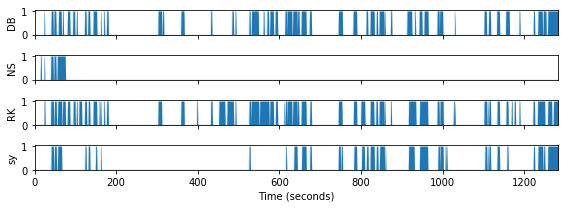

 
******************* c_happy_face *********************


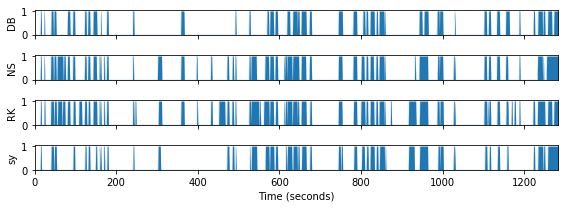

 
******************* c_happy_verbal *********************


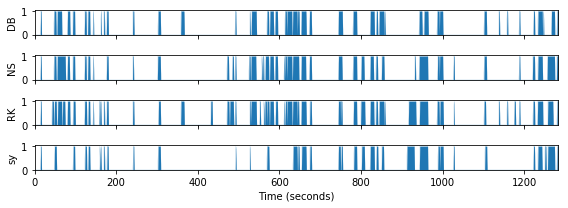

 
******************* c_hope_body *********************


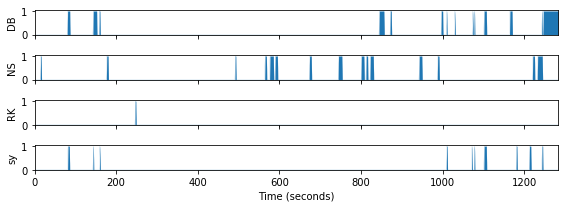

 
******************* c_hope_face *********************


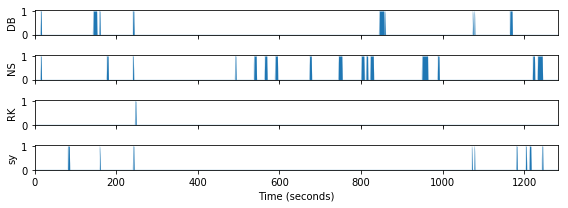

 
******************* c_hope_verbal *********************


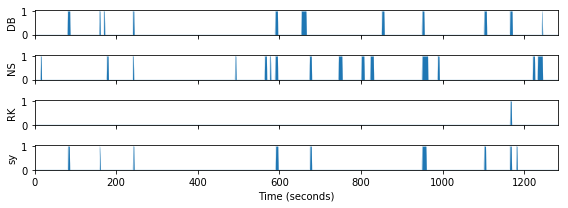

 
******************* c_othneg_body *********************


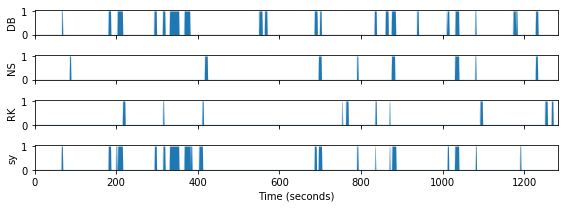

 
******************* c_othneg_face *********************


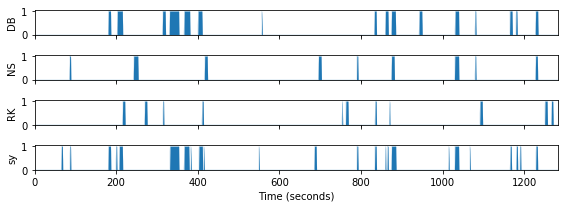

 
******************* c_othneg_verbal *********************


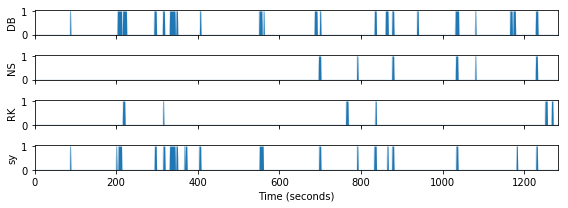

 
******************* c_othpos_body *********************


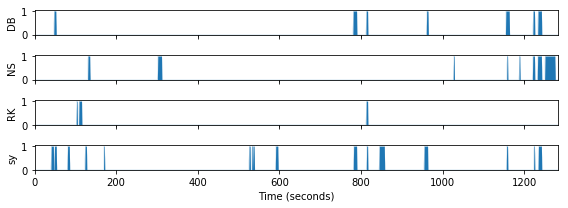

 
******************* c_othpos_face *********************


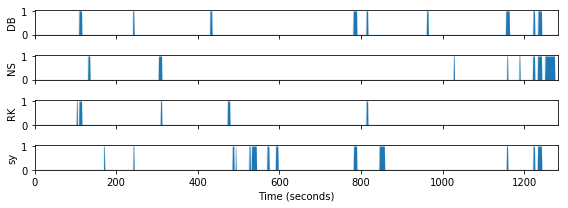

 
******************* c_othpos_verbal *********************


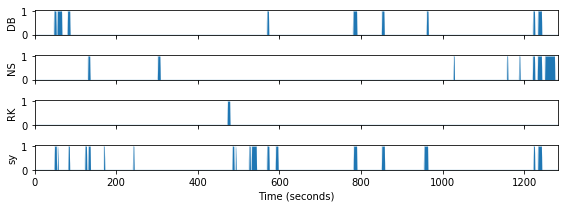

 
******************* c_sad_body *********************


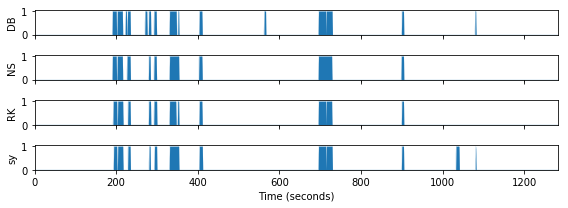

 
******************* c_sad_face *********************


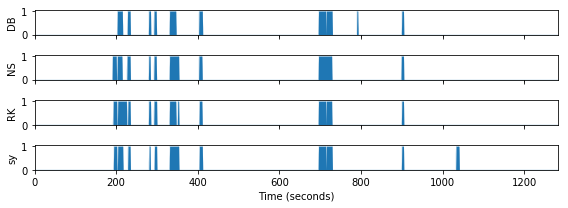

 
******************* c_sad_verbal *********************


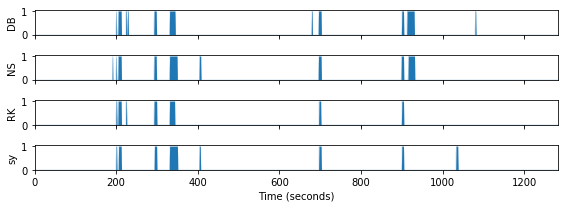

 
******************* c_shame_body *********************


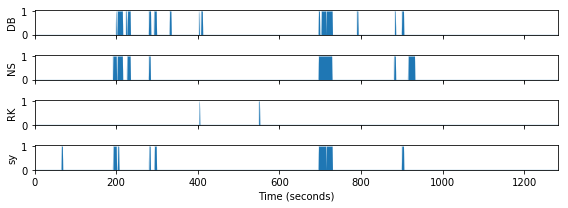

 
******************* c_shame_face *********************


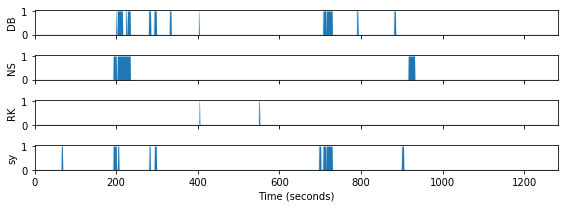

 
******************* c_shame_verbal *********************


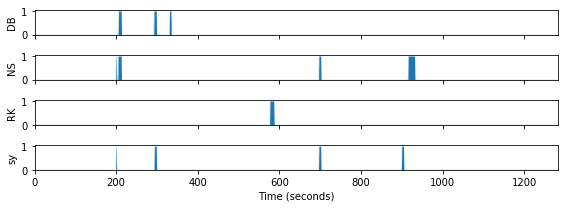

 
******************* c_surprise_body *********************


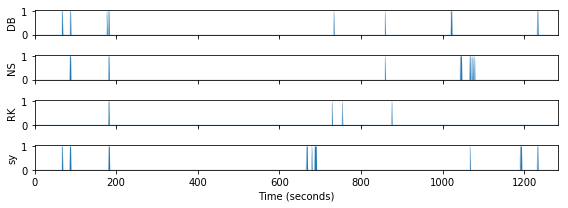

 
******************* c_surprise_face *********************


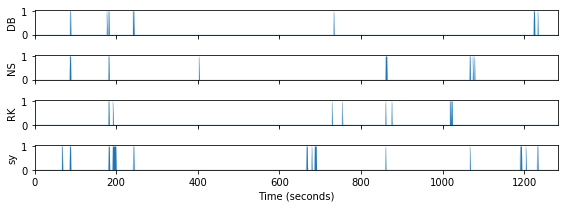

 
******************* c_surprise_verbal *********************


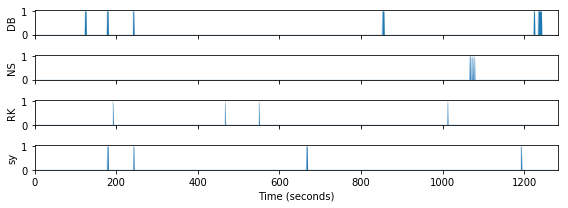

 
******************* char_arousal *********************


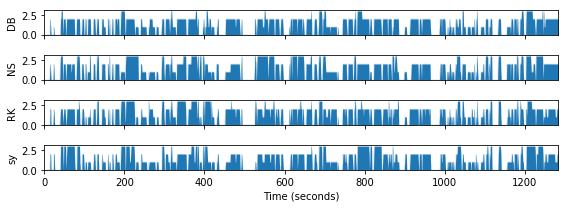

 
******************* char_valence_negative *********************


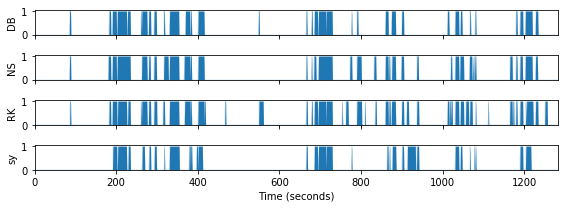

 
******************* char_valence_positive *********************


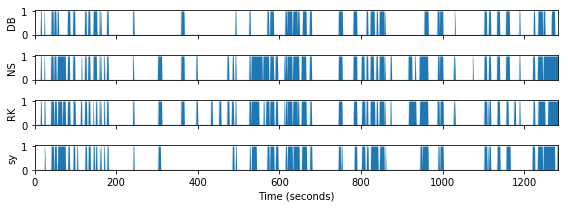

 
******************* d_audience *********************


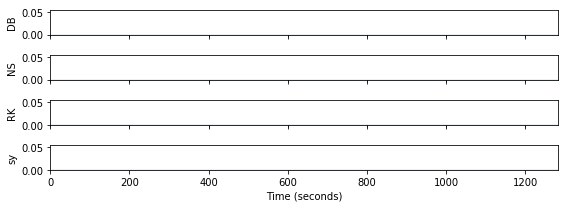

 
******************* d_other *********************


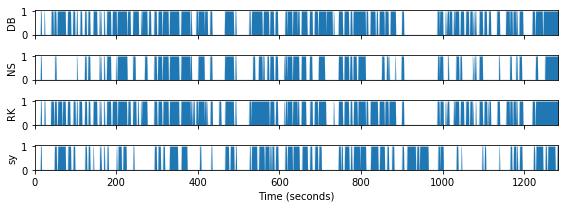

 
******************* d_self *********************


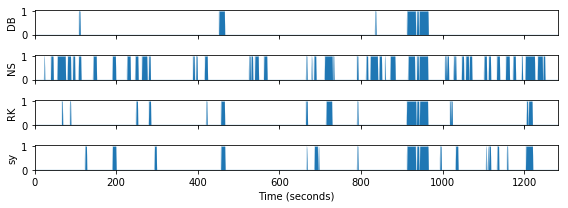

 
******************* on_screen *********************


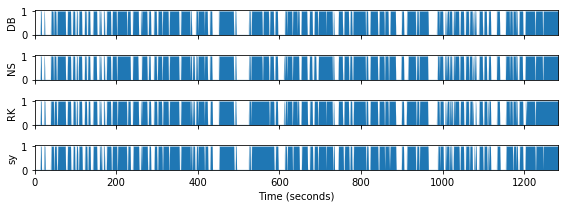

In [10]:
import matplotlib.pyplot as plt
import pandas as pd

dfs = []
raters = []

for file in files:
    rater = file[-22:-20]
    raters.append(rater)
    temp = pd.read_csv(file, index_col=None)
    try:
        temp = temp.drop(string_vars,axis=1)
    except:
        pass
    t = temp['time']/1000
    temp[temp['on_screen']==0] = 0 # for character codes only
    temp['seconds'] = t
    temp.index = pd.to_datetime(t,unit='s')
    temp.index.name = 'time'
    temp = temp.resample('1s').mean().round(0)
    temp.index = temp['seconds']
    
    dfs.append(temp)

variables = ['c_anger_body', 'c_anger_face', 'c_anger_verbal','c_disgust_body', 'c_disgust_face',
       'c_disgust_verbal', 'c_excite_body', 'c_excite_face', 'c_excite_verbal',
       'c_fear_body', 'c_fear_face', 'c_fear_verbal', 'c_happy_body',
       'c_happy_face', 'c_happy_verbal', 'c_hope_body', 'c_hope_face',
       'c_hope_verbal', 'c_othneg_body', 'c_othneg_face', 'c_othneg_verbal',
       'c_othpos_body', 'c_othpos_face', 'c_othpos_verbal', 'c_sad_body',
       'c_sad_face', 'c_sad_verbal', 'c_shame_body', 'c_shame_face',
       'c_shame_verbal', 'c_surprise_body', 'c_surprise_face',
       'c_surprise_verbal', 'char_arousal', 'char_valence_negative',
       'char_valence_positive', 'd_audience', 'd_other', 'd_self', 'on_screen']
for x in variables:
    print('******************* {0} *********************'.format(x))
    fig, ax = plt.subplots(len(dfs), figsize=(8, 0.75*len(dfs)))
    for i, rates in enumerate(dfs):
        try:
            rates[x].plot(kind='area', ax=ax[i], xlabel='Time (seconds)', ylabel=raters[i], sharex=True, xlim=(0,rates.index[-1]), linewidth=0.1)
        except:
            pass
    plt.tight_layout()
    fig.title = x
    plt.savefig('logs/ahkj_subjective_nc_codes_{0}.svg'.format(x))
    plt.show()
    print(' ')

In [11]:
# pull in data and combine into 1 dataframe with a rater column
import pandas as pd

dfs = []
dfs_1hz = []
for file in files:
    rater = file[-22:-20]
    temp = pd.read_csv(file, index_col=None)
    try:
        temp = temp.drop(string_vars,axis=1)
    except:
        pass
    temp.index = pd.to_datetime(temp['time'],unit='ms')
    temp.index.name = 'timeseries'
    temp2 = temp.resample('1s').mean().round(0)
    temp['rater'] = rater
    temp2['rater'] = rater
    dfs.append(temp)
    dfs_1hz.append(temp2)
    
data = pd.concat(dfs)
data1hz = pd.concat(dfs_1hz)
data.columns

Index(['time', 'c_anger_body', 'c_anger_face', 'c_anger_verbal', 'c_comp_body',
       'c_comp_face', 'c_comp_verbal', 'c_disgust_body', 'c_disgust_face',
       'c_disgust_verbal', 'c_excite_body', 'c_excite_face', 'c_excite_verbal',
       'c_fear_body', 'c_fear_face', 'c_fear_verbal', 'c_happy_body',
       'c_happy_face', 'c_happy_verbal', 'c_hope_body', 'c_hope_face',
       'c_hope_verbal', 'c_othneg_body', 'c_othneg_face', 'c_othneg_verbal',
       'c_othpos_body', 'c_othpos_face', 'c_othpos_verbal', 'c_sad_body',
       'c_sad_face', 'c_sad_verbal', 'c_shame_body', 'c_shame_face',
       'c_shame_verbal', 'c_surprise_body', 'c_surprise_face',
       'c_surprise_verbal', 'char_arousal', 'char_valence_negative',
       'char_valence_positive', 'd_audience', 'd_other', 'd_self', 'on_screen',
       'rater'],
      dtype='object')

In [ ]:
# compute ICCs
import pingouin as pg

variables = ['c_anger_body', 'c_anger_face', 'c_anger_verbal','c_disgust_body', 'c_disgust_face',
       'c_disgust_verbal', 'c_excite_body', 'c_excite_face', 'c_excite_verbal',
       'c_fear_body', 'c_fear_face', 'c_fear_verbal', 'c_happy_body',
       'c_happy_face', 'c_happy_verbal', 'c_hope_body', 'c_hope_face',
       'c_hope_verbal', 'c_othneg_body', 'c_othneg_face', 'c_othneg_verbal',
       'c_othpos_body', 'c_othpos_face', 'c_othpos_verbal', 'c_sad_body',
       'c_sad_face', 'c_sad_verbal', 'c_shame_body', 'c_shame_face',
       'c_shame_verbal', 'c_surprise_body', 'c_surprise_face',
       'c_surprise_verbal', 'char_arousal', 'char_valence_negative',
       'char_valence_positive', 'd_audience', 'd_other', 'd_self', 'on_screen']

for x in variables:
    print('********************* {0} *********************'.format(x))
    icc = pg.intraclass_corr(data=data, targets='time',raters='rater',ratings=x, nan_policy='omit').round(3)
    print(icc.set_index('Type'))
    print('')

In [13]:
import pandas as pd
variables = ['c_anger_body', 'c_anger_face', 'c_anger_verbal','c_disgust_body', 'c_disgust_face',
       'c_disgust_verbal', 'c_excite_body', 'c_excite_face', 'c_excite_verbal',
       'c_fear_body', 'c_fear_face', 'c_fear_verbal', 'c_happy_body',
       'c_happy_face', 'c_happy_verbal', 'c_hope_body', 'c_hope_face',
       'c_hope_verbal', 'c_othneg_body', 'c_othneg_face', 'c_othneg_verbal',
       'c_othpos_body', 'c_othpos_face', 'c_othpos_verbal', 'c_sad_body',
       'c_sad_face', 'c_sad_verbal', 'c_shame_body', 'c_shame_face',
       'c_shame_verbal', 'c_surprise_body', 'c_surprise_face',
       'c_surprise_verbal', 'char_arousal', 'char_valence_negative',
       'char_valence_positive', 'd_audience', 'd_other', 'd_self', 'on_screen']
icc_df = pd.DataFrame(columns=['itemICC','meanICC'])
for x in variables:
    print('********************* {0} *********************'.format(x))
    icc = pg.intraclass_corr(data=data1hz, targets='time',raters='rater',ratings=x, nan_policy='omit').round(3)
    icc_df.loc[x,:]=[icc.loc[1,'ICC'],icc.loc[4,'ICC']]
    print(icc.set_index('Type'))
    print('')

********************* c_anger_body *********************
                   Description    ICC      F   df1   df2  pval         CI95%
Type                                                                        
ICC1    Single raters absolute  0.504  5.061  1269  3810   0.0  [0.48, 0.53]
ICC2      Single random raters  0.505  5.163  1269  3807   0.0  [0.48, 0.53]
ICC3       Single fixed raters  0.510  5.163  1269  3807   0.0  [0.48, 0.54]
ICC1k  Average raters absolute  0.802  5.061  1269  3810   0.0  [0.78, 0.82]
ICC2k    Average random raters  0.803  5.163  1269  3807   0.0  [0.78, 0.82]
ICC3k     Average fixed raters  0.806  5.163  1269  3807   0.0  [0.79, 0.82]

********************* c_anger_face *********************
                   Description    ICC      F  df1  df2   pval          CI95%
Type                                                                        
ICC1    Single raters absolute -0.009  0.963  270  813  0.641  [-0.05, 0.04]
ICC2      Single random raters -0.002 

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/pingouin/reliability.py:312: RuntimeWarning: invalid value encountered in double_scalars
  icc1 = (msb - msw) / (msb + (k - 1) * msw)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/pingouin/reliability.py:313: RuntimeWarning: invalid value encountered in double_scalars
  icc2 = (msb - mse) / (msb + (k - 1) * mse + k * (msj - mse) / n)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/pingouin/reliability.py:314: RuntimeWarning: invalid value encountered in double_scalars
  icc3 = (msb - mse) / (msb + (k - 1) * mse)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/pingouin/reliability.py:315: RuntimeWarning: invalid value encountered in double_scalars
  icc1k = (msb - msw) / msb
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/pingouin/reliability.py:316: RuntimeWarning: invalid value encountere

                   Description  ICC   F   df1   df2  pval       CI95%
Type                                                                 
ICC1    Single raters absolute  NaN NaN  1269  3810   NaN  [nan, nan]
ICC2      Single random raters  NaN NaN  1269  3807   NaN  [nan, nan]
ICC3       Single fixed raters  NaN NaN  1269  3807   NaN  [nan, nan]
ICC1k  Average raters absolute  NaN NaN  1269  3810   NaN  [nan, nan]
ICC2k    Average random raters  NaN NaN  1269  3807   NaN  [nan, nan]
ICC3k     Average fixed raters  NaN NaN  1269  3807   NaN  [nan, nan]

********************* d_other *********************
                   Description    ICC      F   df1   df2  pval         CI95%
Type                                                                        
ICC1    Single raters absolute  0.092  1.406  1269  3810   0.0  [0.07, 0.12]
ICC2      Single random raters  0.154  2.078  1269  3807   0.0  [0.08, 0.22]
ICC3       Single fixed raters  0.212  2.078  1269  3807   0.0  [0.18, 0.24]
IC

In [14]:
icc_df.to_csv('iccs_ahkj_sc_julien.csv')